In [38]:
! pip install hurst
! pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data

downloads the data and calculates Hurst exp for TA35 every day for the whole period

In [39]:
import warnings
warnings.filterwarnings('ignore')


In [40]:
# basic data
import pandas as pd
import yfinance as yf
import requests
from bs4 import BeautifulSoup as bs
import os
import numpy as np
from hurst import compute_Hc
import ta
import matplotlib.pyplot as plt
import pickle
# Download only the basic data. open, close, high, low, stock
# get list of TA-35 stocks from wikipedia
resp = requests.get('https://en.wikipedia.org/wiki/TA-125_Index')
soup = bs(resp.text, 'lxml')
tables = soup.find_all('table', {'class': 'wikitable'})
table = tables[1]
tickers = []

for row in table.find_all('tr')[1:]:
        cells = row.find_all('td')
        if len(cells) >= 2:
            ticker = cells[1].text.strip()
            tickers.append(ticker)

all_stocks = [x.replace('\n','') for x in tickers]
all_stocks = [x + '.TA' for x in all_stocks]

# Download historical price data for each TA-35 stock
all_df = pd.DataFrame()
start_date = '2016-01-01'
end_date = '2021-01-01'
fname_string = 'TA125_stocks_' + start_date + '_' + end_date + '.csv'

# Check if the CSV file already exists
if os.path.exists(fname_string):
    # If the file exists, load the data from the file
    all_df = pd.read_csv(fname_string, index_col=0)
else:
    # If the file doesn't exist, download the data and save it to the file
    all_df = pd.DataFrame()

    for tkr in all_stocks:
        try:
            single_stock_pd = yf.download(tickers=tkr, start=start_date, end=end_date, auto_adjust=True)
            single_stock_pd['stock'] = tkr

            all_df = all_df.append(single_stock_pd[['Open', 'High', 'Low', 'Close', 'Volume', 'stock']])
            print(f'Downloaded data for {tkr}.')
        except:
            print(f'Error downloading data for {tkr}')

    # Save the dataframe to a CSV file
    all_df.to_csv(fname_string)

In [41]:
#Calculate the thecnhical status- Hurst, Mean reverse, direacion

# Define rolling window size
window_size = 100

# Define mean reversal window size and threshold
mean_reversal_window = 15
mean_reversal_threshold = 0.05

# Calculate the Hurst exponent for each window
hurst_list = []
yield_list = []
for i in range(window_size, len(all_df)):
    try:
        H, c, data = compute_Hc(all_df['Close'][i-window_size:i].values, kind='price', simplified=True)
        hurst_list.append(H)
    except FloatingPointError:
        hurst_list.append(np.nan)
    yield_list.append((all_df['Close'][i] - all_df['Close'][i-1]) / all_df['Close'][i-1])

# Add the Hurst exponent values to the dataframe
all_df = all_df.iloc[window_size:]
all_df['Hurst'] = hurst_list
all_df['Yield'] = yield_list

# Add MeanReverse and Direction columns
all_df['MeanReverse'] = np.nan
all_df['Hurst_Direction'] = np.nan

for i in range(mean_reversal_window, len(all_df)):
    prev_close = all_df['Close'][i-mean_reversal_window:i].mean()
    curr_close = all_df['Close'][i]
    mean_reverse = (curr_close - prev_close) / prev_close
    if abs(mean_reverse) > mean_reversal_threshold:
        direction = np.sign(mean_reverse)
    else:
        direction = 0
    all_df['MeanReverse'].iloc[i] = mean_reverse
    all_df['Hurst_Direction'].iloc[i] = direction

# Drop unnecessary columns and rows with NaN values
all_df = all_df[['Open', 'High', 'Low', 'Close', 'Volume', 'stock', 'Hurst', 'Yield', 'Hurst_Direction']]
all_df = all_df.fillna(0)
all_df['Wallet'] = 1000


# Indicators

frama

In [42]:
def calculate_frama(data, n):
  # # Create a new DataFrame for calculations
  # calc_atr_df = pd.DataFrame()

  # # Copy necessary columns to the new DataFrame
  # calc_atr_df['High'] = all_df['High']
  # calc_atr_df['Low'] = all_df['Low']
  # calc_atr_df['Close'] = all_df['Close']

  # # Calculate ATR values
  # atr_period = 14  # ATR period
  # atr = AverageTrueRange(high=calc_atr_df['High'], low=calc_atr_df['Low'], close=calc_atr_df['Close'], window=n)
  # atr_values = atr.average_true_range()

  # # Add the ATR values to the DataFrame
  # calc_atr_df['ATR'] = atr_values
  # n = 10  # EMA window size
  k = 2 / (n + 1)  # Smoothing factor
  frama_values = [data['Close'].iloc[0]]  # Initialize the FRAMA list with the first value

  for i in range(1, len(data)):
      ema = (data['Close'].iloc[i] * k) + (frama_values[i-1] * (1 - k))
      atr = calc_atr_df['ATR'].iloc[i]
      frama = ema + atr * 0.25  # Adjusted FRAMA formula
      frama_values.append(frama)

  # Add the FRAMA values to the DataFrame
  data['FRAMA'] = frama_values
  return data

from ta.volatility import AverageTrueRange
# # Create a new DataFrame for calculations
# calc_atr_df = pd.DataFrame()

# # Copy necessary columns to the new DataFrame
# calc_atr_df['High'] = all_df['High']
# calc_atr_df['Low'] = all_df['Low']
# calc_atr_df['Close'] = all_df['Close']

# # Calculate ATR values
# atr_period = 14  # ATR period
# atr = AverageTrueRange(high=calc_atr_df['High'], low=calc_atr_df['Low'], close=calc_atr_df['Close'], window=atr_period)
# atr_values = atr.average_true_range()

# # Add the ATR values to the DataFrame
# calc_atr_df['ATR'] = atr_values

DPO

In [43]:
def calculate_dpo(data, n):
    close_prices = data['Close']
    sma = close_prices.rolling(window=n).mean().shift(int(n / 2) + 1)
    dpo = close_prices - sma
    return dpo

# Define the period for DPO calculation
n = 20

# Calculate DPO for each stock in the DataFrame
for stock in all_df['stock'].unique():
    mask = all_df['stock'] == stock
    all_df.loc[mask, 'DPO'] = calculate_dpo(all_df.loc[mask], n)

Chaikin

In [44]:
# Chaikin oscillator indicator
def calculate_co(data):
    # Create a new DataFrame for calculations
    calc_df = pd.DataFrame()

    # Copy necessary columns to the new DataFrame
    calc_df['High'] = data['High']
    calc_df['Low'] = data['Low']
    calc_df['Close'] = data['Close']

    # Calculate Co indicator
    calc_df['CO'] = ta.trend.cci(high=calc_df['High'], low=calc_df['Low'], close=calc_df['Close'], window=20, constant=0.015)

    # Merge Co indicator to the original DataFrame
    data['CO'] = calc_df['CO']

    return data

# # Calculate co for each stock in the DataFrame
co_df = calculate_co(all_df.copy())  # Calculate Co indicator in a separate DataFrame
all_df['CO'] = co_df['CO']  # Add Co indicator to the original DataFrame


def calculate_co_direction(co_values, window_size, consecutive_days):
    direction = []
    for i in range(len(co_values)):
        if i < window_size:
            direction.append(0)
        else:
            count = 0
            for j in range(i-window_size+1, i+1):
                if co_values[i] > co_values[j-1]:
                    count += 1
            if count >= consecutive_days:
                direction.append(1)
            else:
                direction.append(0)
    return direction


# calculate Chaikin oscillator directon
co_values = all_df['CO'].values
window_size = 20
consecutive_days = 12

co_direction = calculate_co_direction(co_values, window_size, consecutive_days)
all_df['CO_Direction'] = co_direction



```
# This is formatted as code
```

# in and out of sample data

In [45]:
# Convert index to datetime
all_df.index = pd.to_datetime(all_df.index)

# Split the data into in-sample and out-of-sample periods
in_periods = [('2016-12-30', '2018-12-31')]
out_periods = [('2019-01-01', '2021-01-01')]

# inSample_1 = all_df.loc['2012-01-01':'2013-12-31']  # Initialize an empty DataFrame for the in-sample data
#inSample_2 = all_df.loc['2012-01-01':'2014-12-31']
#inSample_3 = all_df.loc['2018-01-01':'2020-12-31']
inSample = pd.DataFrame()

# Slice the in-sample periods from the all_df DataFrame and concatenate them
for start_date, end_date in in_periods:
    in_df = all_df.loc[start_date:end_date]
    inSample = pd.concat([inSample, in_df])

# outSample_1 = all_df.loc['2009-01-01':'2011-12-31']  # Initialize an empty DataFrame for the in-sample data
# outSample_2 = all_df.loc['2014-01-01':'2016-12-31']
outSample = pd.DataFrame()
for start_date, end_date in out_periods:
    out_df = all_df.loc[start_date:end_date]
    outSample = pd.concat([outSample, out_df])


update daily wallet based on daily yield

In [46]:
def calculate_daily_yield(Sample_df):
    new_df = pd.DataFrame()  # Create a new empty DataFrame to store the modified results

    unique_stocks = Sample_df['stock'].unique()
    for stock in unique_stocks:
        stock_data = Sample_df[Sample_df['stock'] == stock]
        stock_wallet = [1000]  # Initialize the Wallet with 1000

        for i in range(1, len(stock_data)):
            daily_yield = (stock_data['Close'].iloc[i] - stock_data['Close'].iloc[i - 1]) / stock_data['Close'].iloc[i - 1]
            wallet_value = stock_wallet[i - 1] * (1 + daily_yield)
            stock_wallet.append(wallet_value)

        stock_data['Wallet'] = stock_wallet  # Add the Wallet column to the stock data
        new_df = pd.concat([new_df, stock_data])  # Concatenate the modified stock data to the new DataFrame
    return new_df

#functions

Daily Sharpe ratio calculator

In [47]:
def calculate_sharpe_ratio(yield_list, risk_free_rate):
    mean_return = np.mean(yield_list) * 16
    std_return = np.std(yield_list)
    excess_return = mean_return - risk_free_rate
    sharpe_ratio = excess_return / std_return
    return sharpe_ratio

calculates the return of all the trades of a given stock

In [48]:
def calculate_returns(tkr, trades):
    # Filter trades for the given stock symbol
    trades = [t for t in trades if t[0] == tkr]
    wallet = 1000
    # Check if there are any trades for the given stock symbol
    if len(trades) == 0:
        return 0, 0

    # Calculate returns for each trade
    returns = []
    for i in range(0, len(trades)-1, 2):
        buy_price = trades[i][3]
        sell_price = trades[i+1][3]
        r = (sell_price - buy_price) / buy_price
        wallet -= buy_price
        wallet += sell_price
        returns.append(r)

    # Calculate mean and standard deviation of returns
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    return mean_return, std_return, wallet

summerizes the yield for all the stocks per day and returns a list of all of them

In [49]:
from pandas._config import dates
def portfolio_maker(df):
    df_sorted = df.sort_index()
    unique_dates = df_sorted.index.unique()
    # Create a multi-index DataFrame
    df_multi = df.set_index(['stock', df.index])
    bag_list = []
    dates = []
    for date in unique_dates:
        bag = 0
        for stock in df['stock'].unique():
            try:
                wallet_info = df_multi.loc[(stock, date), 'Wallet']
                bag += wallet_info.sum()  # Sum the wallet info for the specific date and stock
            except KeyError:
                bag += 1000
        bag_list.append(bag)
        dates.append(date)

    yield_list = []
    for i in range(len(bag_list)-1):
        yield_val = (bag_list[i+1] - bag_list[i]) / bag_list[i]
        yield_list.append(yield_val)

    # Create DataFrame with dates and bag_list values
    result_df = pd.DataFrame({'Date': dates[:-1], 'Bag': bag_list[:-1]})

    return yield_list, result_df

# buy and hold for the outSample

In [50]:
wallet_update_in = calculate_daily_yield(inSample)
daily_yield_list_in, lis = portfolio_maker(wallet_update_in)
calculate_sharpe_ratio(daily_yield_list_in, 0.0)

0.48562718348701034

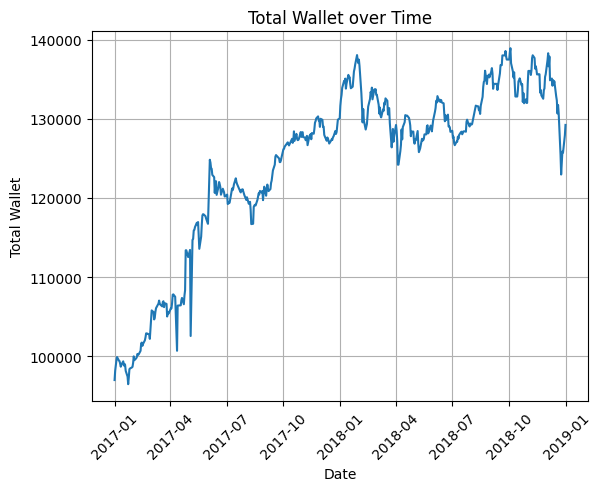

In [51]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' with 'Date' as the index and 'Wallet' column

# Group the data by date and calculate the sum of wallet values for each date
total_wallet = wallet_update_in.groupby(wallet_update_in.index)['Wallet'].sum()
missing_dates = pd.to_datetime(['2018-09-19', '2018-10-14'])
days_before = [1, 3]
for date, days in zip(missing_dates, days_before):
    prev_date = date - pd.DateOffset(days=days)

    total_wallet.loc[date] = total_wallet.loc[prev_date]

total_wallet = total_wallet.sort_index()

# Plot the total wallet over time
plt.plot(total_wallet.index, total_wallet)
plt.xlabel('Date')
plt.ylabel('Total Wallet')
plt.title('Total Wallet over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [52]:
import pandas as pd

missing_dates = pd.to_datetime(['2018-09-19', '2018-10-14'])
days_before = [1, 3]

total_wallet = wallet_update_in.groupby(wallet_update_in.index)['Wallet'].sum()

for date, days in zip(missing_dates, days_before):
    prev_date = date - pd.DateOffset(days=days)

    total_wallet.loc[date] = total_wallet.loc[prev_date]

total_wallet = total_wallet.sort_index()



#14.10.18, 19.9.18 תאריכים בעייתיים

# buy & sell strategy - the Hurst exponent



In [53]:

def strategy_hurst(data_hurst, stop_loss_pct, value):
    position = 0
    trades_hurst = []
    wallet = 1000

    for i in range(len(data_hurst)):
        current_year = data_hurst.index[i].year
        next_year = data_hurst.index[i + 1].year if i + 1 < len(data_hurst) else None
        if position == 1:
            wallet += wallet*data_hurst['Yield'][i]
        data_hurst['Wallet'][i] = wallet
        if next_year is not None and next_year > current_year:
            if position == 1:
                buy_price = data_hurst['Close'][i]
                trades_hurst.append((tkr, 'sell', data_hurst.index[i], buy_price))
                position = 0

        if data_hurst['Hurst'][i] > value and data_hurst['Hurst_Direction'][i] == 1 and (data_hurst['DPO'][i] > 0 or data_hurst['CO_Direction'][i] == 1):
            # Enter long position
            if position <= 0:
                buy_price = data_hurst['Close'][i]
                stop_loss_price = buy_price * (1 - stop_loss_pct)
                trades_hurst.append((tkr, 'buy', data_hurst.index[i], buy_price, stop_loss_price))
                position = 1

        elif data_hurst['Hurst'][i] < 1 - value and data_hurst['Hurst_Direction'][i] == -1 and data_hurst['DPO'][i] < 0:

            # Exit long position
            if position == 1:
                buy_price = data_hurst['Close'][i]
                trades_hurst.append((tkr, 'sell', data_hurst.index[i], buy_price))
                position = 0

        if position == 1 and data_hurst['Low'][i] <= stop_loss_price:
            sell_price = stop_loss_price
            trades_hurst.append((tkr, 'sell', data_hurst.index[i], sell_price))
            position = 0

    # Exit any remaining position at the end of the data_hurst
    if position == 1:
        sell_price = data_hurst['Close'][-1]
        trades_hurst.append((tkr, 'sell', data_hurst.index[-1], sell_price))
    # print(wallet)
    return data_hurst, trades_hurst



optimization - hurst

Value: 0.30, Sharpe Ratio: 0.32
Value: 0.35, Sharpe Ratio: 0.22
Value: 0.40, Sharpe Ratio: 0.21
Value: 0.45, Sharpe Ratio: 0.22
Value: 0.50, Sharpe Ratio: 0.26
Value: 0.55, Sharpe Ratio: 0.32
Value: 0.60, Sharpe Ratio: 0.28
Value: 0.65, Sharpe Ratio: 0.24
Value: 0.70, Sharpe Ratio: 0.23
Value: 0.75, Sharpe Ratio: 0.22


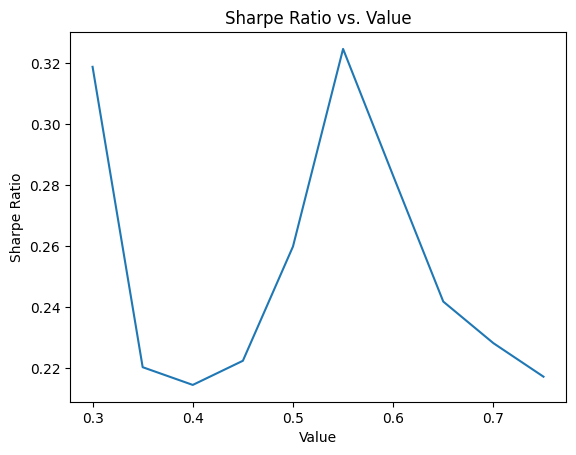

In [54]:
values = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
sharpe_ratios_hurst = []
#empty_df = pd.DataFrame(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'stock', 'Hurst', 'Yield', 'Hurst_Direction', 'Wallet'])

for value in values:
    # Loop over all stocks in the inSample dataset
    empty_df = pd.DataFrame(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'stock', 'Hurst', 'Yield', 'Hurst_Direction', 'Wallet'])
    inSample_trades_hurst = []
    yield_portfolio = []
    sharpe_ratio = 0
    stop_loss_pct = 0.5
    for tkr in inSample['stock'].unique():
        data = inSample[inSample['stock'] == tkr].copy()
        df, trades_hurst = strategy_hurst(data, stop_loss_pct, value)
        empty_df = pd.concat([empty_df, df], ignore_index=False)
        inSample_trades_hurst.extend(trades_hurst)

    # Combine all trades_hurst into a single list
    all_trades_hurst = []
    yield_portfolio, total_wallet = portfolio_maker(empty_df)

    # Calculate Sharpe Ratio of the portfolio
    sharpe_ratio = calculate_sharpe_ratio(yield_portfolio, 0.0)
    sharpe_ratios_hurst.append(sharpe_ratio)

    print(f'Value: {value:.2f}, Sharpe Ratio: {sharpe_ratio:.2}')

plt.plot(values, sharpe_ratios_hurst)
plt.xlabel('Value')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio vs. Value')
plt.show()

Value: 0.55, Sharpe Ratio: 0.32


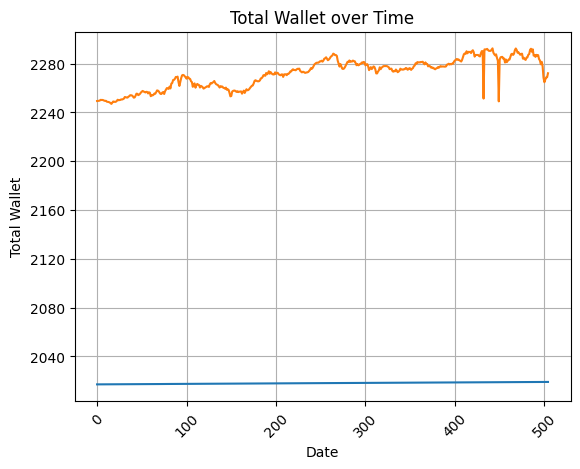

In [55]:
values = [0.55]
sharpe_ratios_hurst = []


for value in values:
    # Loop over all stocks in the inSample dataset
    empty_df = pd.DataFrame(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'stock', 'Hurst', 'Yield', 'Hurst_Direction', 'Wallet'])
    inSample_trades_hurst = []
    stop_loss_pct = 0.5
    for tkr in inSample['stock'].unique():
        data = inSample[inSample['stock'] == tkr].copy()
        df, trades_hurst = strategy_hurst(data, stop_loss_pct, value)
        empty_df = pd.concat([empty_df, df], ignore_index=False)
        inSample_trades_hurst.extend(trades_hurst)

    # Combine all trades_hurst into a single list
    all_trades_hurst = []
    yield_portfolio, total_wallet = portfolio_maker(empty_df)

    # Calculate Sharpe Ratio of the portfolio
    sharpe_ratio = calculate_sharpe_ratio(yield_portfolio, 0.00)
    sharpe_ratios_hurst.append(sharpe_ratio)

    print(f'Value: {value:.2f}, Sharpe Ratio: {sharpe_ratio:.2}')

# Plot the total wallet over time
plt.plot(total_wallet.index, total_wallet)
plt.xlabel('Date')
plt.ylabel('Total Wallet')
plt.title('Total Wallet over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


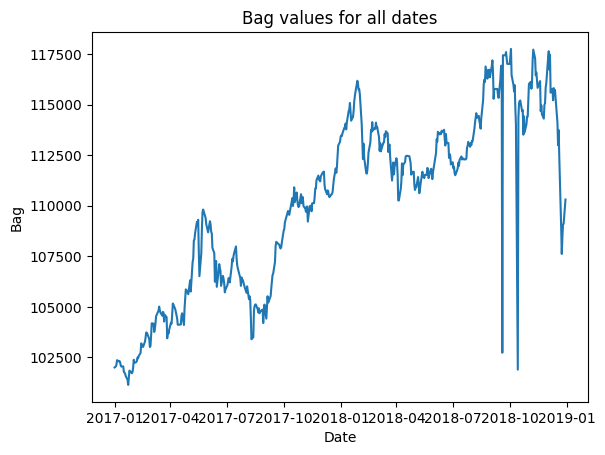

In [56]:
# Plotting the bag values

plt.plot(total_wallet['Date'], total_wallet['Bag'])
plt.xlabel('Date')
plt.ylabel('Bag')
plt.title('Bag values for all dates')
plt.show()

In [57]:
empty_df = pd.DataFrame(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'stock', 'Hurst', 'Yield', 'Hurst_Direction', 'Wallet'])
inSample_trades_hurst = []
stop_loss_pct = 0.5
for tkr in inSample['stock'].unique():
    data = inSample[inSample['stock'] == tkr].copy()
    df, trades_hurst = strategy_hurst(data, stop_loss_pct, 0.5)
    empty_df = pd.concat([empty_df, df], ignore_index=False)
    inSample_trades_hurst.extend(trades_hurst)


# buy & sell rule by  frama



In [58]:

def strategy_frama(data_frama, stop_loss_pct):
    position = 0
    trades_frama = []
    wallet = 1000


    for i in range(len(data_frama)):

        if position == 1:
            wallet += wallet*data_frama['Yield'][i]
        data_frama['Wallet'][i] = wallet

        if data_frama['FRAMA'][i] > data_frama['Close'][i] and position <= 0 and (data_frama['DPO'][i] > 0 or data_frama['CO_Direction'][i] == 1):
            # Enter long position
            if position <= 0:
                buy_price = data_frama['Close'][i]
                stop_loss_price = buy_price * (1 - stop_loss_pct)
                trades_frama.append((tkr, 'buy', data_frama.index[i], buy_price, stop_loss_price))
                position = 1

        elif position == 1 and data_frama['FRAMA'][i] < data_frama['Close'][i] and data_frama['DPO'][i] < 0:
            # Exit long position
            buy_price = data_frama['Close'][i]
            trades_frama.append((tkr, 'sell', data_frama.index[i], buy_price))
            position = 0
        if position == 1 and data_frama['Low'][i] <= stop_loss_price:
            sell_price = stop_loss_price
            trades_frama.append((tkr, 'sell', data_frama.index[i], sell_price))
            position = 0

    # Exit any remaining position at the end of the data_farma
    if position == 1:
        sell_price = data_frama['Close'][-1]
        trades_frama.append((tkr, 'sell', data_frama.index[-1], sell_price))
    return data_frama, trades_frama



Value: 10.00, Sharpe Ratio: 0.41
Value: 21.00, Sharpe Ratio: 0.42
Value: 30.00, Sharpe Ratio: 0.42
Value: 50.00, Sharpe Ratio: 0.41
Value: 70.00, Sharpe Ratio: 0.40
Value: 100.00, Sharpe Ratio: 0.34
Value: 115.00, Sharpe Ratio: 0.35
Value: 130.00, Sharpe Ratio: 0.33
Value: 150.00, Sharpe Ratio: 0.35


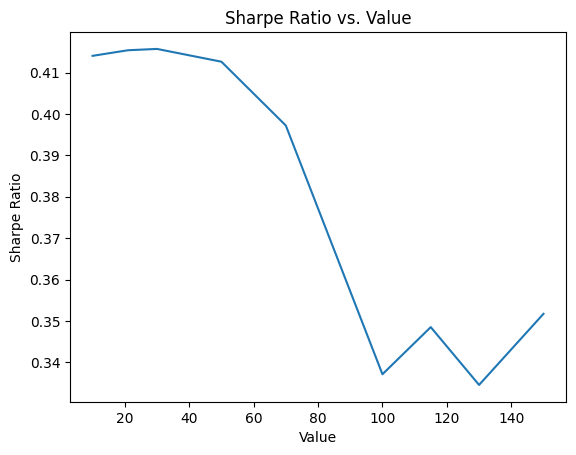

In [59]:
values = [10, 21, 30, 50, 70, 100, 115, 130, 150]
sharpe_ratios_frama = []

for value in values:
    empty_df = pd.DataFrame(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'stock', 'Hurst', 'Yield', 'Hurst_Direction', 'Wallet'])
    inSample_trades_frama = []
    yield_portfolio = []
    stop_loss_pct = 0.25
    # Create a new DataFrame for calculations
    calc_atr_df = pd.DataFrame()

    # Copy necessary columns to the new DataFrame
    calc_atr_df['High'] = all_df['High']
    calc_atr_df['Low'] = all_df['Low']
    calc_atr_df['Close'] = all_df['Close']

    # Calculate ATR values
    # atr_period = 14  # ATR period
    atr = AverageTrueRange(high=calc_atr_df['High'], low=calc_atr_df['Low'], close=calc_atr_df['Close'], window=value)
    atr_values = atr.average_true_range()

    # Add the ATR values to the DataFrame
    calc_atr_df['ATR'] = atr_values
    for tkr in inSample['stock'].unique():
        data_frama = inSample[inSample['stock'] == tkr].copy()
        data_frama = calculate_frama(data_frama, value)
        df, trades_frama = strategy_frama(data_frama, stop_loss_pct)
        empty_df = pd.concat([empty_df, df], ignore_index=False)
        inSample_trades_frama.extend(trades_frama)

    all_trades_frama = []
    yield_portfolio, stam = portfolio_maker(empty_df)


    returns = []
    sharpe_ratio = calculate_sharpe_ratio(yield_portfolio, 0.00)
    sharpe_ratios_frama.append(sharpe_ratio)

    print(f'Value: {value:.2f}, Sharpe Ratio: {sharpe_ratio:.2f}')
    # inSample = inSample.drop('FRAMA', axis=1)
plt.plot(values, sharpe_ratios_frama)
plt.xlabel('Value')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio vs. Value')
plt.show()


Value: 10.00, Sharpe Ratio: 0.41


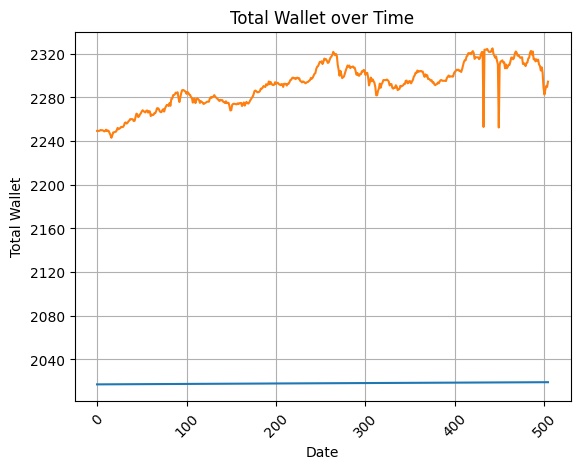

In [60]:
values = [10]
sharpe_ratios_frama = []

for value in values:
    empty_df = pd.DataFrame(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'stock', 'Hurst', 'Yield', 'Hurst_Direction', 'Wallet'])
    inSample_trades_frama = []
    yield_portfolio = []
    stop_loss_pct = 0.25
    # Create a new DataFrame for calculations
    calc_atr_df = pd.DataFrame()

    # Copy necessary columns to the new DataFrame
    calc_atr_df['High'] = all_df['High']
    calc_atr_df['Low'] = all_df['Low']
    calc_atr_df['Close'] = all_df['Close']

    # Calculate ATR values
    # atr_period = 14  # ATR period
    atr = AverageTrueRange(high=calc_atr_df['High'], low=calc_atr_df['Low'], close=calc_atr_df['Close'], window=value)
    atr_values = atr.average_true_range()

    # Add the ATR values to the DataFrame
    calc_atr_df['ATR'] = atr_values
    for tkr in inSample['stock'].unique():
        data_frama = inSample[inSample['stock'] == tkr].copy()
        data_frama = calculate_frama(data_frama, value)
        df, trades_frama = strategy_frama(data_frama, stop_loss_pct)
        empty_df = pd.concat([empty_df, df], ignore_index=False)
        inSample_trades_frama.extend(trades_frama)

    all_trades_frama = []
    yield_portfolio, total_wallet = portfolio_maker(empty_df)


    returns = []
    sharpe_ratio = calculate_sharpe_ratio(yield_portfolio, 0.00)
    sharpe_ratios_frama.append(sharpe_ratio)

    print(f'Value: {value:.2f}, Sharpe Ratio: {sharpe_ratio:.2f}')
    # inSample = inSample.drop('FRAMA', axis=1)

    # Plot the total wallet over time
plt.plot(total_wallet.index, total_wallet)
plt.xlabel('Date')
plt.ylabel('Total Wallet')
plt.title('Total Wallet over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


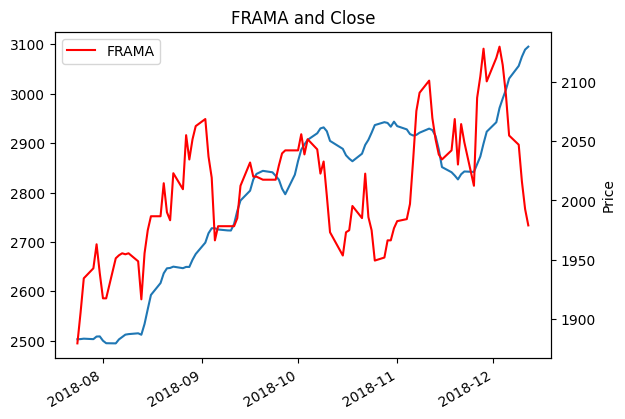

In [63]:
empty_df["FRAMA"][1400:1500].plot(title="FRAMA")
empty_df["Close"][1400:1500].plot(secondary_y=True, style='r', title="FRAMA and Close")

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['FRAMA', 'Close'])
plt.show()
